In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

lags=60
precent_train_set = 0.99
rolling_value = 10

In [2]:
def AR(p, df, test=True):
    df_temp = df
    
    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    train_size = (int)(precent_train_set * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()

    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    return df_train_2,df_test,theta.reshape((len(theta),)),intercept[0],RMSE

In [3]:
def claculate_metrics_model(y, y_pred, name, count_parameters):
    return pd.DataFrame({'name':[name],
                              'r2':[r2_score(y, y_pred)],
                              'RMSE':[np.sqrt(mean_squared_error(y, y_pred))],
                              'MAE':[mean_absolute_error(y, y_pred)],
                              'sum_squared_resid':[np.sum((y - y_pred)**2)],
                              'AIC':[len(y) * np.log(np.sum((y - y_pred)**2) / len(y)) + 2*count_parameters],
                              'durbin_watson': [durbin_watson(y - y_pred)],
                        'theil_index':[np.sqrt((1/len(y_pred))*np.sum((y-y_pred)**2))
                                      / (np.sqrt((1/len(y))*np.sum(y**2)) + np.sqrt((1/len(y_pred))*np.sum(y_pred**2)))],
                        }
        )

In [4]:
def MA(q, res):
    
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    train_size = (int)(precent_train_set * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
#     res_test[['Residuals','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

#     print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta.reshape((len(theta),)),intercept[0],RMSE]

In [5]:
file1 = open('ATS_lab_05_GARCH/ARCH_01.dat')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

In [6]:
date = np.array('1992-02', dtype=np.datetime64)
date = date + np.arange(len(y))

In [7]:
df_y = pd.DataFrame({'Date': date, 'Value':y})
df_y = df_y.set_index('Date')

## Visualizate the data

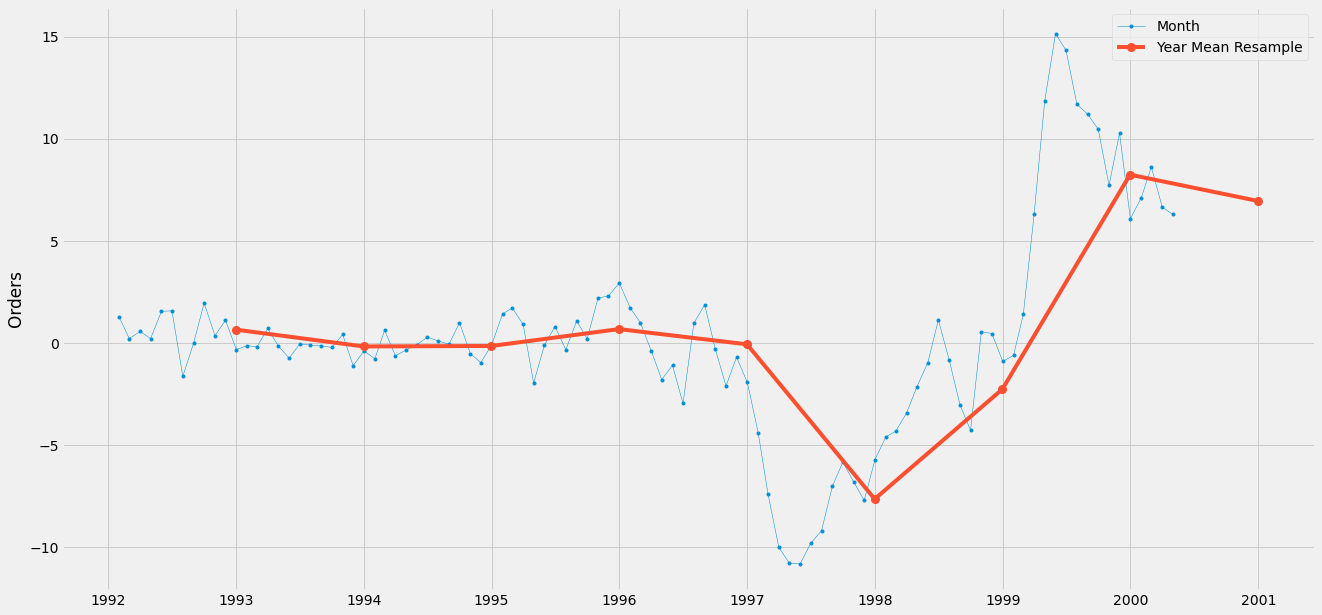

In [8]:
y = df_y
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

## Decomposing Data 

In [9]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

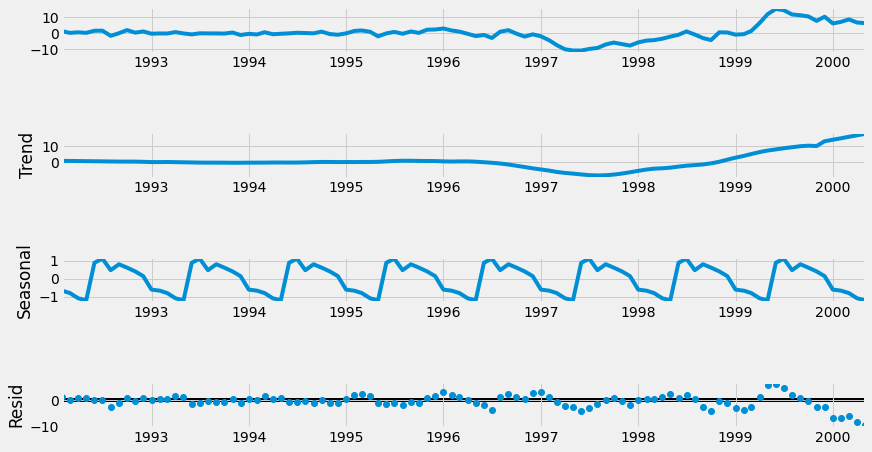

In [10]:
seasonal_decompose(df_y)

## Checking Stationarity

In [11]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=rolling_value).mean() 
    rolstd = pd.Series(timeseries).rolling(window=rolling_value).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

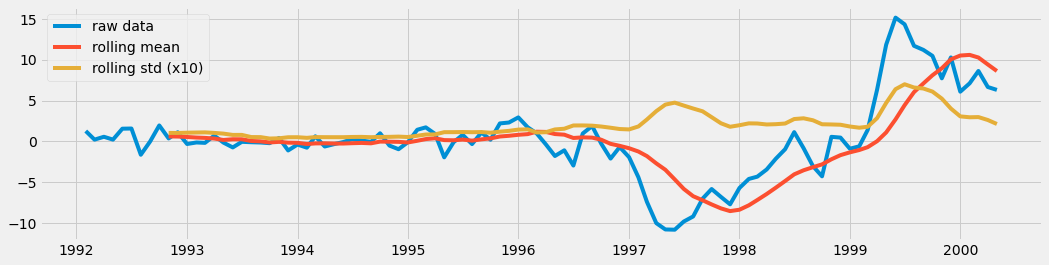

In [12]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y.Value,'raw data')

##  Augmented Dickey-Fuller Test

In [13]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [14]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.847
P-value = 0.357
Critical values :
	1%: -3.4989097606014496 - The data is not stationary with 99% confidence
	5%: -2.891516256916761 - The data is not stationary with 95% confidence
	10%: -2.5827604414827157 - The data is not stationary with 90% confidence


## Detrending

 > Is the de-trended data stationary ?
Test statistic = -4.681
P-value = 0.000
Critical values :
	1%: -3.505190196159122 - The data is  stationary with 99% confidence
	5%: -2.894232085048011 - The data is  stationary with 95% confidence
	10%: -2.5842101234567902 - The data is  stationary with 90% confidence


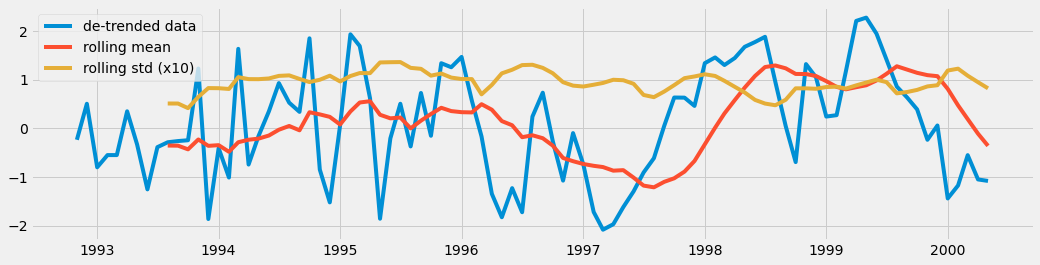

In [15]:
# Detrending
y_detrend =  (y - y.rolling(window=rolling_value).mean())/y.rolling(window=rolling_value).std()

test_stationarity(y_detrend.Value,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Differencing

 > Is the 1 lag differenced data stationary ?
Test statistic = -8.681
P-value = 0.000
Critical values :
	1%: -3.4989097606014496 - The data is  stationary with 99% confidence
	5%: -2.891516256916761 - The data is  stationary with 95% confidence
	10%: -2.5827604414827157 - The data is  stationary with 90% confidence


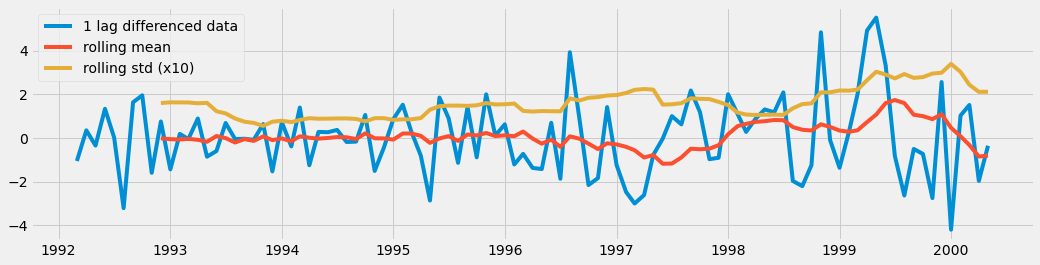

In [16]:
# Differencing
diff_model = 1
y_10lag =  y - y.shift(diff_model)

test_stationarity(y_10lag.Value,f'{diff_model} lag differenced data')
ADF_test(y_10lag,f'{diff_model} lag differenced data')

## Combining Detrending and Differencing

 > Is the 1 lag differenced de-trended data stationary ?
Test statistic = -8.617
P-value = 0.000
Critical values :
	1%: -3.5078527246648834 - The data is  stationary with 99% confidence
	5%: -2.895382030636155 - The data is  stationary with 95% confidence
	10%: -2.584823877658872 - The data is  stationary with 90% confidence


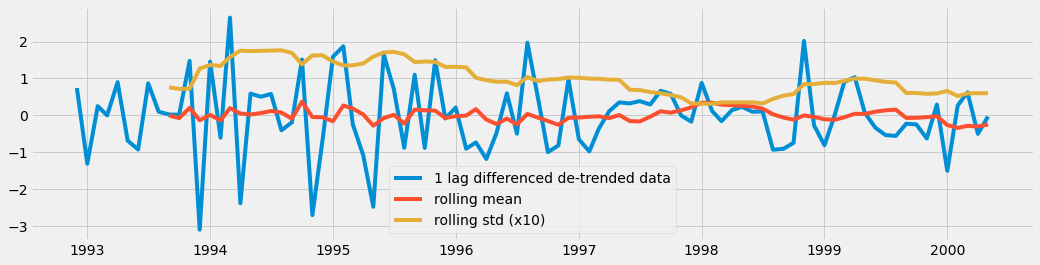

In [17]:
y_10lag_detrend =  y_detrend - y_detrend.shift(diff_model)

test_stationarity(y_10lag_detrend.Value,f'{diff_model} lag differenced de-trended data')
ADF_test(y_10lag_detrend.Value,f'{diff_model} lag differenced de-trended data')

In [18]:
def calculate_metrics_sample(y):
   
    print('yes')
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return pd.DataFrame(np.array([[metr] for metr in y_dict.values()]).T, 
                        columns=['series', 'observations', 'mode','mean','median',
                                 'variation','skewness','kurtosis','jarque-bera','probability'])#,'params_ar','params_intercept'])

In [19]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(20,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample, marker='o')
    plt.grid(True)
    plt.show();
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

## Calculate metrics for real series

In [20]:
calculate_metrics_sample(y.Value).T

yes


,0
series,Y
observations,100
mode,-10.8
mean,0.26336948000000016
median,-0.08315
variation,23.952130550609265
skewness,0.5651009056726102
kurtosis,1.606938376958063
jarque-bera,14.14615235392492
probability,0.00084762166036223


In [21]:
y.describe()

,Value
count,100.00000000
mean,0.26336948
std,4.89409139
min,-10.80000000
25%,-1.09100000
50%,-0.08315000
75%,1.30925000
max,15.15000000


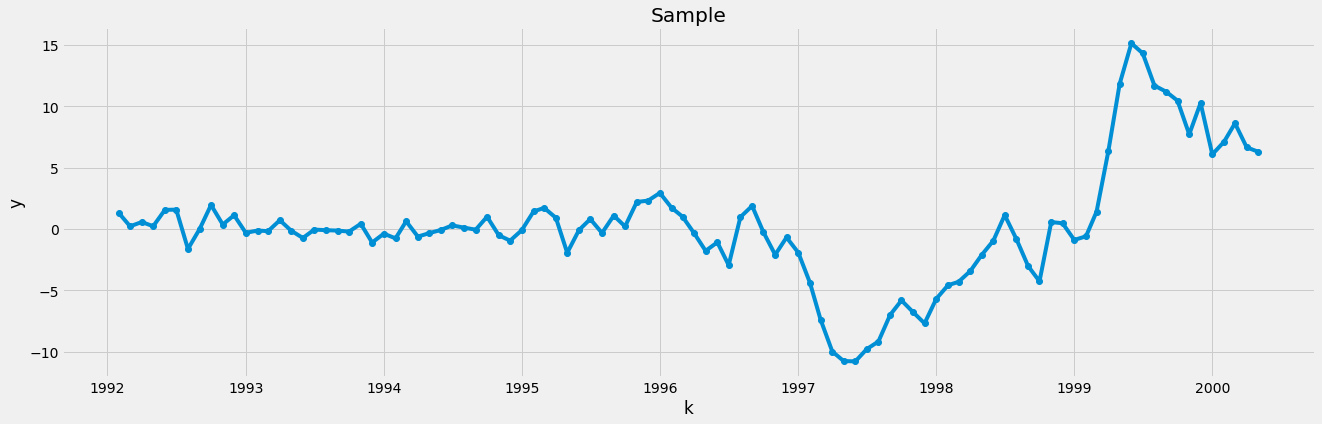

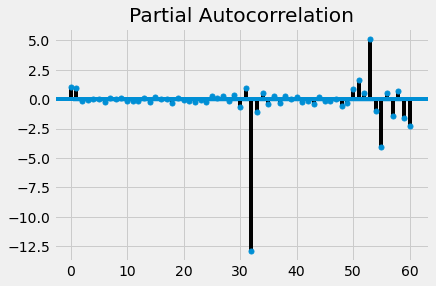

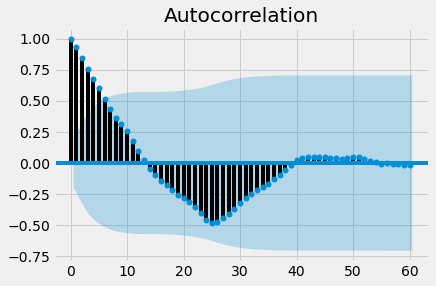

In [22]:
show_plots(y.Value)

## Building AR(1) for time series (1.4)

In [23]:
def show_prediction(y, y_pred, name='', pred_title='pred'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y.Value[y_pred.index], label='y', marker='o')
    plt.plot(y_pred, label=pred_title, marker='o')
    plt.legend()
    plt.show()

In [24]:
columns =['name', 'r2', 'RMSE','MAE','sum_squared_resid','AIC','durbin_watson','theil_index']
models_metrics = pd.DataFrame(columns=columns)

p = 1
df_train_ar,df_test_ar,theta_ar_ar,intercept_ar,RMSE = AR(p,pd.DataFrame(y.Value))
metric = claculate_metrics_model(df_train_ar.Value, df_train_ar.Predicted_Values, f'AR({p})', p)
models_metrics = models_metrics.append(metric)

df_c_ar = pd.concat([df_train_ar,df_test_ar])

models_metrics

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),0.87548140,1.72180168,1.30180065,290.53089996,108.50076109,1.69001619,0.18214974


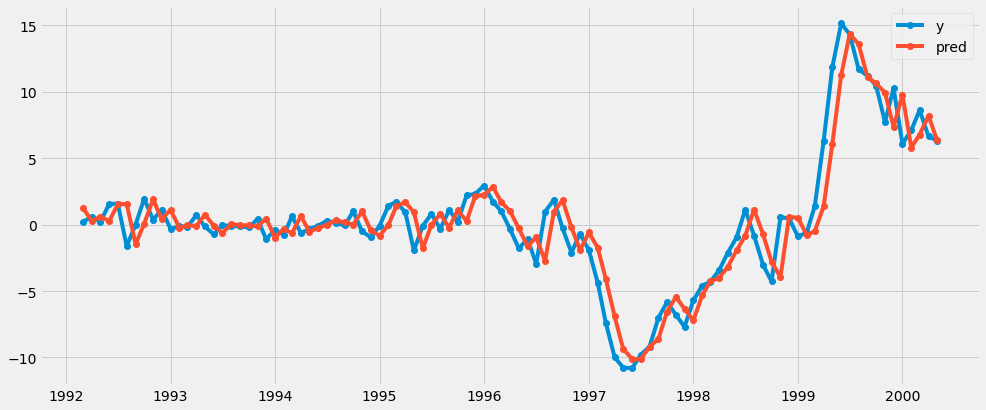

In [25]:
show_prediction(y, df_c_ar.Predicted_Values)

In [26]:
# Coef for AR
print(f'thetta:\n{theta_ar_ar}')
print(f'intercept:\n{intercept_ar}')

thetta:
[0.94399607]
intercept:
0.06261103717606673


In [27]:
res = pd.DataFrame()
res['Residuals'] = df_c_ar.Value - df_c_ar.Predicted_Values
res['Residuals_2'] = np.power(res.Residuals, 2)

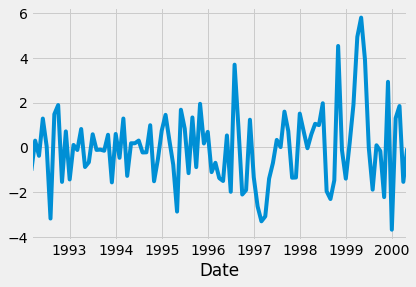

In [28]:
res['Residuals'].plot()

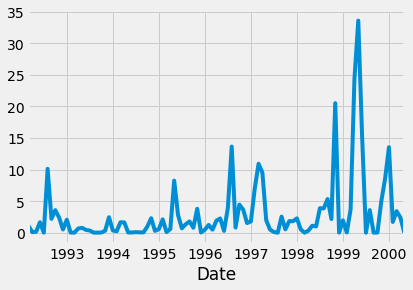

In [29]:
res['Residuals_2'].plot()

## ACF for resid^2 (1.5\\6)

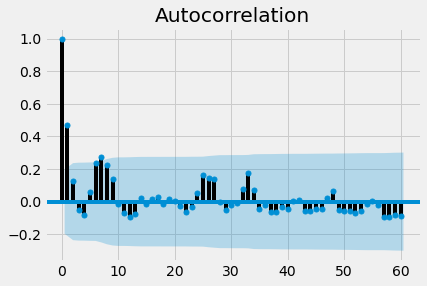

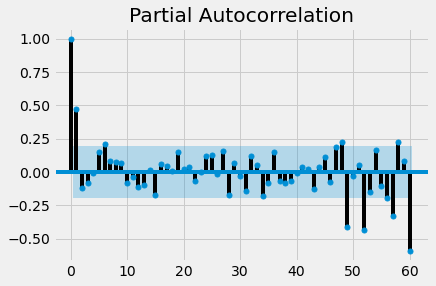

In [30]:
plot_acf(res.Residuals_2.values, lags=lags);
plot_pacf(res.Residuals_2.values, lags=lags);

## Build Autoregressive conditional heteroskedasticity (ARCH(1)) (1.7)


In [31]:
df_res = pd.DataFrame({'Value': res.Residuals_2})
p = 1
df_train_arch,df_test_arch,theta_arch,intercept_arch,RMSE = AR(p,pd.DataFrame(df_res.Value))
metric = claculate_metrics_model(df_train_arch.Value, df_train_arch.Predicted_Values, f'ARCH({p})', p)
models_metrics = models_metrics.append(metric)
metric

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,ARCH(1),0.22095267,4.65353443,2.75363308,2100.57211905,300.29964244,1.88897633,0.46830176


In [32]:
print(f'thetta:\n{theta_arch}')
print(f'intercept:\n{intercept_arch}')

thetta:
[0.46977636]
intercept:
1.588413034868683


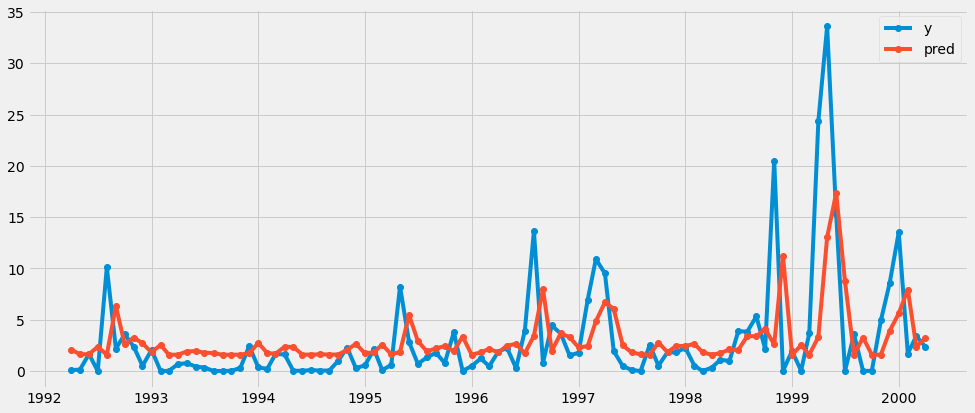

In [33]:
show_prediction(df_train_arch, df_train_arch.Predicted_Values)

### Coefficients for ARCH(1)

## ARCH(4) (1.8)

In [34]:
p = 4
df_train_arch_4, df_test_arch_4,theta_arch_4,intercept_arch_4,RMSE = AR(p,pd.DataFrame(df_res.Value))
metric = claculate_metrics_model(df_train_arch_4.Value, df_train_arch_4.Predicted_Values, f'ARCH({p})', p)
models_metrics = models_metrics.append(metric)
metric

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,ARCH(4),0.23427317,4.67029817,2.87668089,2050.29839356,297.74990869,1.99857890,0.45987421


### Coefficisents for ARCH(4)

In [35]:
print(f'thetta:\n{theta_arch_4}')
print(f'intercept:\n{intercept_arch_4}')

thetta:
[ 0.51307305 -0.07555434 -0.08511915  0.00579209]
intercept:
1.960158294686768


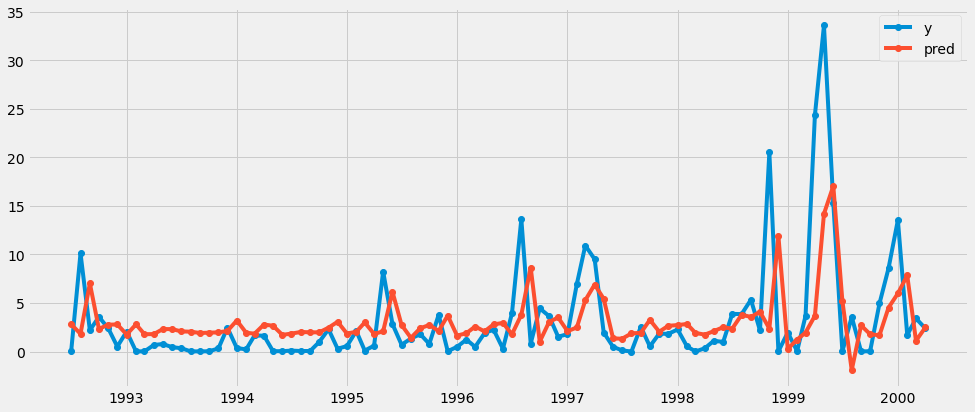

In [36]:
show_prediction(df_train_arch_4, df_train_arch_4.Predicted_Values)

## calculating condition variotion for procces (1.9)

In [37]:
def get_condition(y):
    y_real = list(y)
#     y_real = y.copy()
    h_k = []
    # mean = y
    for k in range(2, len(y_real)):
        value_h = []
        mean_k = (1/(k - 1)) * (sum(y_real[1:k+1]))
#         print(f'mean:\t{mean_k}')
        for i in range(1, k+1):
            value_h.append((y_real[i] - mean_k)**2)

        h_k.append((1/(k-1)) * sum(value_h)) 
#     return h_k
    return pd.DataFrame({'Value': h_k, 'Date':y.index[2:]}).set_index('Date')

In [38]:
h_k = get_condition(y.Value)

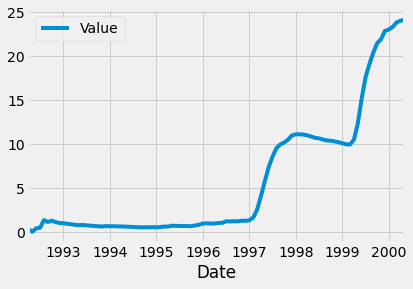

In [39]:
h_k.plot()

## generalized autoregressive conditional heteroskedasticity(GARCH)

\begin{align}
h(x) & = \alpha_0  +\left( \sum_{k=1}^q \alpha_i (\epsilon(k-1))^2 \right) + ...
\end{align}

### ACF for condition variations (h_k(x))

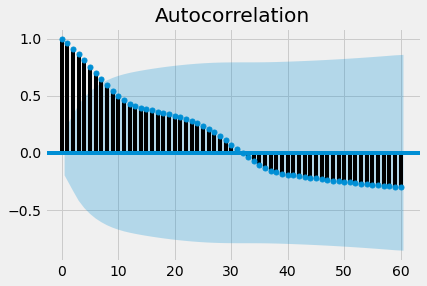

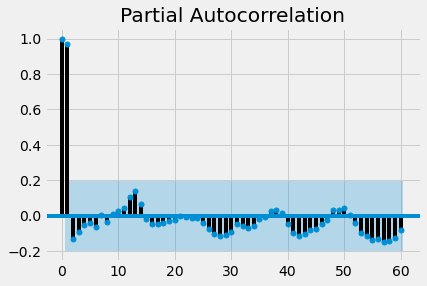

In [40]:
plot_acf(h_k.Value, lags=lags);
plot_pacf(h_k.Value, lags=lags);

In [41]:
res_new = pd.DataFrame()
res_new['Residuals'] = res.Residuals_2[h_k.index]

#### ACF for Residuals^2

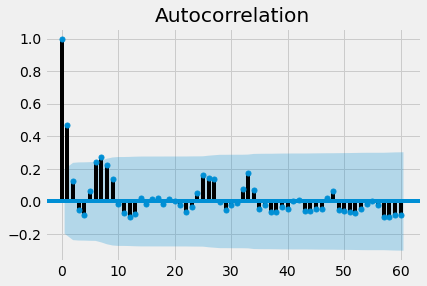

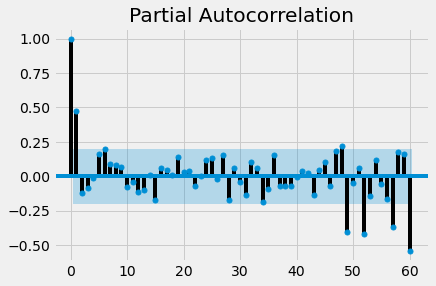

In [42]:
plot_acf(res_new.Residuals, lags=lags);
plot_pacf(res_new.Residuals, lags=lags);

In [43]:
p = 8
q = 7
df_train_garch_ar, df_test_garch_ar,theta_garch_ar,intercept_garch_ar,RMSE = AR(p,pd.DataFrame(h_k.Value))
metric = claculate_metrics_model(df_train_garch_ar.Value, df_train_garch_ar.Predicted_Values, f'GARCH({p})', p)
metric

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,GARCH(8),0.99879632,0.24567616,0.15664208,5.37175282,-233.86590741,1.94910397,0.01318435


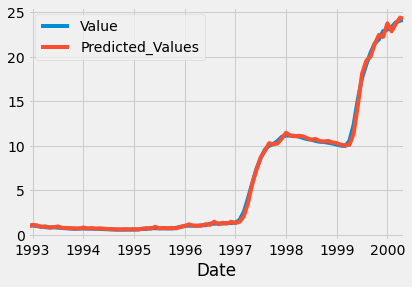

In [44]:
df_c_garch = pd.concat([df_train_garch_ar,df_test_garch_ar])
df_c_garch[['Value','Predicted_Values']].plot()

## building MA model for res^2

In [45]:
df_train_garch_ma, df_test_garch_ma,theta_garch_ma,intercept_garch_ma,_ = MA(q,pd.DataFrame(res_new.Residuals))
metric = claculate_metrics_model(df_train_garch_ma.Residuals, df_train_garch_ma.Predicted_Values, f'GARCH({q})', p)
metric

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,GARCH(7),0.30535063,4.49450496,2.66641338,1818.05173197,286.51399535,2.01165077,0.43126585


## Coefficients  for (1.9)

In [46]:
print(f'thetta AR:\n{theta_garch_ar}')
print(f'thetta MA:\n{theta_garch_ma}')

print(f'intercept:\n{intercept_garch_ma + intercept_garch_ar}')

thetta AR:
[ 2.21304912 -1.56295457  0.31559723 -0.07509342  0.2219855  -0.06479664
 -0.16899703  0.12870846]
thetta MA:
[ 0.50338878 -0.08731706 -0.03708423 -0.05249768  0.04619402  0.16095413
  0.07921462]
intercept:
1.2445260094881783


In [47]:
res_c_garch = pd.concat([df_train_garch_ma, df_test_garch_ma])
df_c_garch_first = df_c_garch.copy()
df_c_garch_first.Predicted_Values += res_c_garch.Predicted_Values

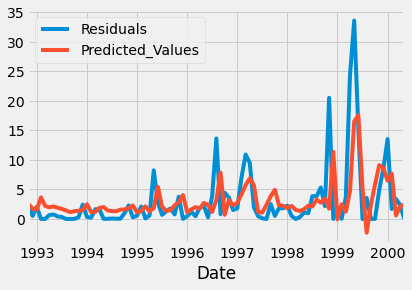

In [48]:
res_c_garch[['Residuals','Predicted_Values']].plot()

### Result metrics for (1.9)

In [49]:
claculate_metrics_model(df_c_garch_first.dropna().Value, df_c_garch_first.dropna().Predicted_Values, f'GARCH({p,q})', p+q)

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"GARCH((8, 7))",0.67386139,4.16530632,3.06124353,1561.47990445,286.82216732,0.52909080,0.18637645


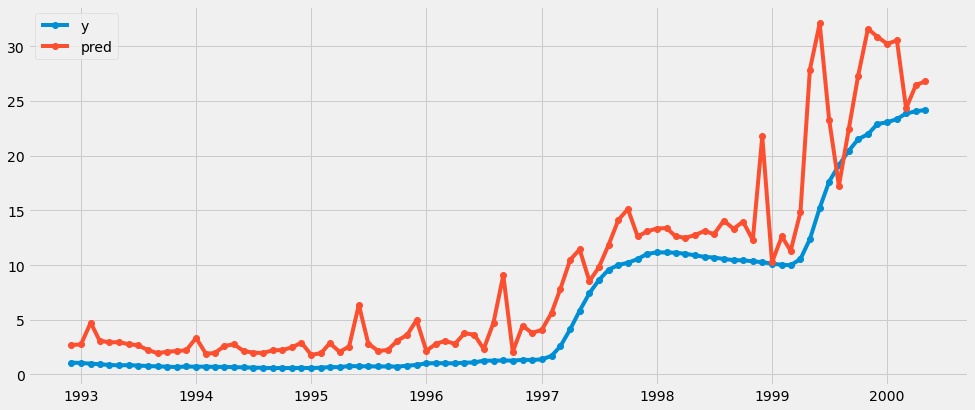

In [50]:
show_prediction(df_c_garch_first, df_c_garch_first.dropna().Predicted_Values)

## Create condition residuals(1.10)

# ---------------------------------

In [55]:
h_k = get_condition(res.Residuals)

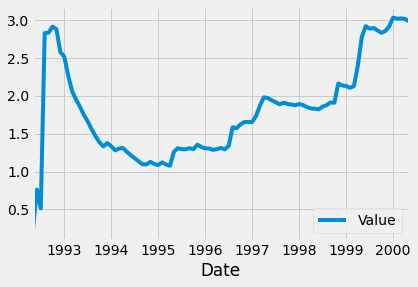

In [56]:
h_k.plot()

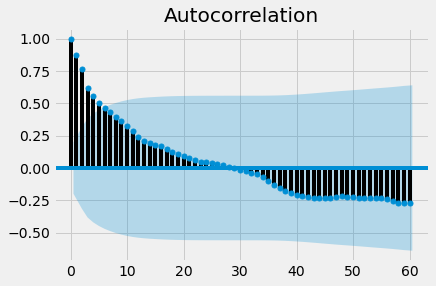

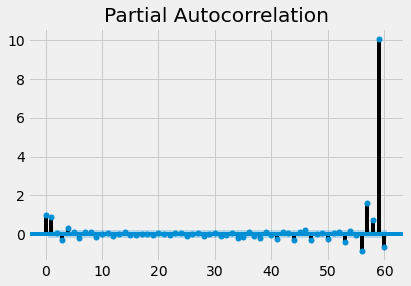

In [57]:
plot_acf(h_k.Value, lags=lags);
plot_pacf(h_k.Value, lags=lags);

In [ ]:
p = 6
q = 7
df_train_garch_ar, df_test_garch_ar,theta_garch_ar,intercept_garch_ar,RMSE = AR(p,pd.DataFrame(h_k.Value))
metric = claculate_metrics_model(df_train_garch_ar.Value, df_train_garch_ar.Predicted_Values, f'GARCH({p})', p)
metric

## PACT and ACF for condition residuals 

In [51]:
res_h_k = get_condition(res.Residuals).rename(columns={'Value': 'Residuals'})

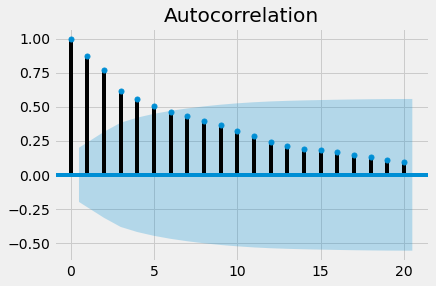

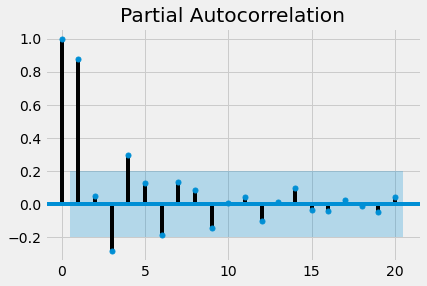

In [52]:
plot_acf(res_h_k.Residuals);
plot_pacf(res_h_k.Residuals);

In [53]:
q = 5
df_train_garch_gs, df_test_garch_gs,theta_garch_gs, intercept_garch_gs, _ = MA(q,pd.DataFrame(res_h_k.Residuals))
metric = claculate_metrics_model(df_train_garch_gs.Residuals, df_train_garch_gs.Predicted_Values, f'GARCH({p,q})', p+q)
metric

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"GARCH((8, 5))",0.98345647,0.07513363,0.05017359,0.51370071,-445.10463050,1.93533506,0.01969819


## Coefficients for (1.10)

# --------------------------------------------------

In [55]:
print(f'thetta AR:\n{theta_garch_ar}')
print(f'thetta MA:\n{theta_garch_gs}')

print(f'intercept:\n{intercept_garch_gs + intercept_garch_ar}')

thetta AR:
[ 2.21304912 -1.56295457  0.31559723 -0.07509342  0.2219855  -0.06479664
 -0.16899703  0.12870846]
thetta MA:
[ 1.46756789 -0.41097122 -0.08433642 -0.08232647  0.10369324]
intercept:
0.04536031832988141


In [56]:
res_c_garch_gs = pd.concat([df_train_garch_gs, df_test_garch_gs])

df_c_garch_gs = df_c_garch.copy()
df_c_garch_gs.Predicted_Values += res_c_garch_gs.Predicted_Values

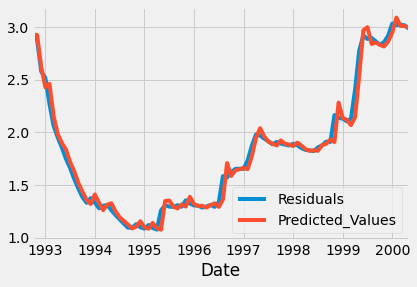

In [57]:
res_c_garch_gs[['Residuals', 'Predicted_Values']].plot()

### Result metrics for 1.10

In [58]:
claculate_metrics_model(df_c_garch_gs.dropna().Value, df_c_garch_gs.dropna().Predicted_Values, f'GARCH({p,q})', p+q)

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"GARCH((8, 5))",0.93205666,1.90116273,1.80548722,325.29777701,141.64381965,0.03385798,0.09131821


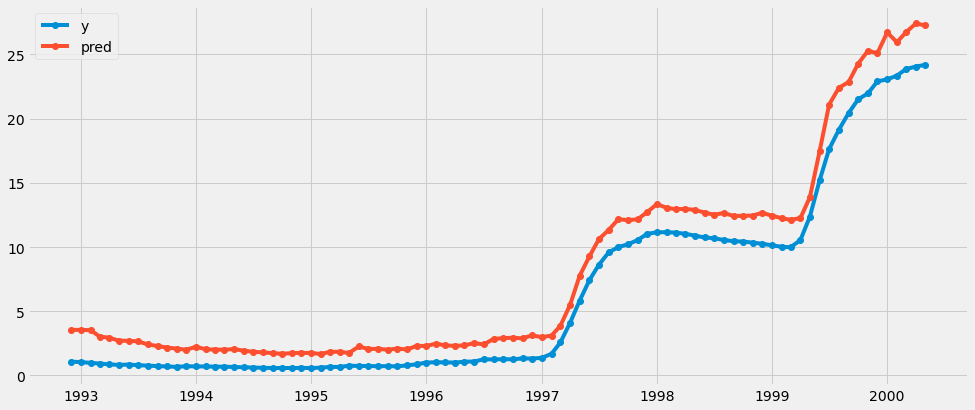

In [59]:
show_prediction(df_c_garch_gs, df_c_garch_gs.dropna().Predicted_Values)